<a href="https://colab.research.google.com/github/DataChemE/Histopathologic-Cancer-Detection/blob/main/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!unzip -q /content/drive/MyDrive/histopathologic-cancer-detection.zip

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16742301950320910609
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40427651072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7002214191822784040
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17341972694576085548
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40427651072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15733940699900946986
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
             

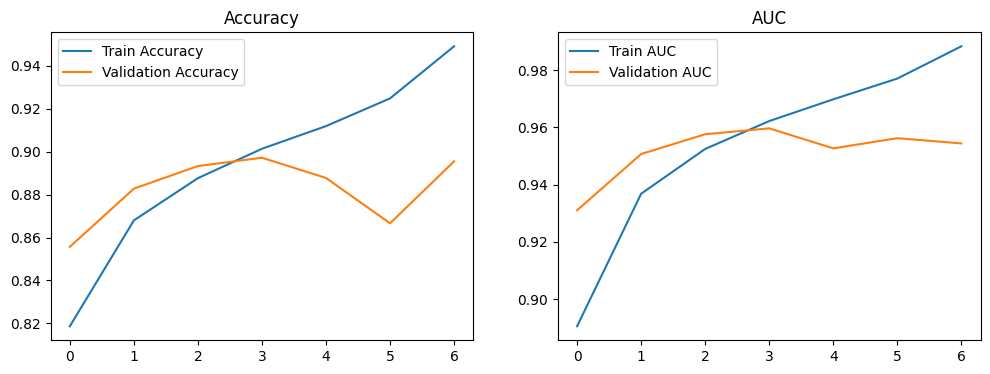

1796/1796 [==============================] - 47s 26ms/step
Submission file created: submission.csv
                                         id  label
0  b8056734c8281fe9ff123254c99066444ac1289d      1
1  a17204199e115d2a9bf808f180f67e70e1b06e6c      1
2  15d65c9e713e787b3ce213bb36d6dd61b68bc38f      1
3  760978f31a69da3dc10af680a0e7edeadbb4ea5a      0
4  d7f024e37a85c06ad70816b647d33fc5b4a654be      1
5  db6a9e5d34ad63b051d8cfa33daa18f3aba794e6      0
6  d8f45ad1aa61da7da756d335080506ed6a64abdd      1
7  733bd16cce7704792745724fda03f9e05c6744a7      0
8  947170bb7a8012f2f04d7c85aa8085c1d5b0532a      1
9  898891884eaa94bd5b04ce18c550819f90a71779      0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# Check if GPUs are available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Define paths
BASE_PATH = '/content/histopathologic-cancer-detection'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'train_labels.csv')

# Load the training labels
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((96, 96))  # Resize the image
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

def create_dataset(image_ids, labels=None, is_train=True):
    def gen():
        for i, id in enumerate(image_ids):
            image_path = os.path.join(TRAIN_PATH if is_train else TEST_PATH, f"{id}.tif")
            img = load_image(image_path)
            if labels is not None:
                yield img, labels.iloc[i]
            else:
                yield img

    if labels is not None:
        output_signature = (
            tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    else:
        output_signature = tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

    return dataset

# Split data into train and validation sets
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_labels['id'], train_labels['label'], test_size=0.2, random_state=42
)

# Configure the datasets for training
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Calculate steps per epoch
train_steps_per_epoch = len(train_ids) // BATCH_SIZE
val_steps_per_epoch = len(val_ids) // BATCH_SIZE

train_dataset = create_dataset(train_ids, train_labels)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

val_dataset = create_dataset(val_ids, val_labels)
val_dataset = val_dataset.batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

# Prepare the test dataset
test_ids = [filename.split('.')[0] for filename in os.listdir(TEST_PATH) if filename.endswith('.tif')]
test_dataset = create_dataset(test_ids, labels=None, is_train=False)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)  # Ensure no repeat() here

def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))  # 96x96 RGB images
    model.add(layers.Conv2D(32, 3, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Conv2D(64, 3, activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model

model = create_model()
model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    epochs=10,  # Increase the number of epochs
    callbacks=callbacks
)

# Plotting the training history again
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.title('AUC')

plt.show()

# Ensure that the test dataset is correctly batched and does not repeat
predictions = model.predict(test_dataset, verbose=1)

# Round the predictions to 0 or 1
rounded_predictions = np.round(predictions).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'label': rounded_predictions.flatten()
})

# Save submission to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

# Optionally, you can print out a few predictions to verify
print(submission.head(10))
